In [17]:
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer  # Explicitly enable experimental features
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

from dhs_modelling_functions import final_ds_droping_cols, fold_generator

In [18]:
input_dir = "/mnt/datadisk/data/Projects/water/inputs/"
# min_version = 3
overwrite_pqt = True
dataset_type = 'HR'  #, 'BR', 'CR', 'HW', 'IR', 'KR', 'MR', 'PR', 'AR'] ??['AN', 'FC, 'FP', 'HW', 'PV', 'SC'] < 25 surveys
urban_rural_all_mode = 'all' # 'all', 'U', 'R'
group_by_col = 'adm2_gaul'
out_f = 'imputation_results.csv'

# Scale options
scale_all_data = True
# leave_out_encodings = True
# zero_one_scale_categorical = False
# scale_labels = True
# scale_numerical_data = False

# More Options
drop_agriculture = False



in_f = f"{input_dir}5_grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc_{urban_rural_all_mode}.pkl"

In [19]:
input_df = pd.read_pickle(in_f)

for c in input_df.columns:
    if 'year' in c or 'Year' in c:
        print(c)

# if urban_rural_all_mode == 'U':
#     drop_agriculture = True
    
df = final_ds_droping_cols(input_df, drop_meta=True, drop_food_help=True, drop_perc=40,
                           retain_month=False, drop_highly_correlated_cols=False, drop_region=True, 
                 drop_data_sets=['Meta one-hot encoding', 'Meta frequency encoding'], 
                 use_NAN_amount_and_replace_NANs_in_categorical=False, drop_agricultural_cols=drop_agriculture, 
                 drop_below_version=False, numerical_data=['mean'], retain_adm=False, 
                 retain_GEID_init=False, verbose=3)


drop_cols = [c for c in df.columns if 'FS;' in c and not '0-2y' in c]
df = df.drop(columns=drop_cols)

for col in df.columns:
    print(col)
    

Meta; year
DHS Cat; person fetching water: female child under 15 years old
DHS Cat; person fetching water: male child under 15 years old
Dropped Meta one-hot encoding; data: ['Meta one-hot encoding; adm0_gaul: Angola', 'Meta one-hot encoding; adm0_gaul: Benin', 'Meta one-hot encoding; adm0_gaul: Burkina Faso', 'Meta one-hot encoding; adm0_gaul: Burundi', 'Meta one-hot encoding; adm0_gaul: Cameroon', 'Meta one-hot encoding; adm0_gaul: Central African Republic', 'Meta one-hot encoding; adm0_gaul: Chad', 'Meta one-hot encoding; adm0_gaul: Comoros', "Meta one-hot encoding; adm0_gaul: Côte d'Ivoire", 'Meta one-hot encoding; adm0_gaul: Democratic Republic of the Congo', 'Meta one-hot encoding; adm0_gaul: Egypt', 'Meta one-hot encoding; adm0_gaul: Ethiopia', 'Meta one-hot encoding; adm0_gaul: Gabon', 'Meta one-hot encoding; adm0_gaul: Gambia', 'Meta one-hot encoding; adm0_gaul: Ghana', 'Meta one-hot encoding; adm0_gaul: Guinea', 'Meta one-hot encoding; adm0_gaul: Kenya', 'Meta one-hot encodin

In [20]:
# Define a list of imputers to test
imputers = [
    # {"name": "MICE BayesianRidge", "imputer": IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)},
    # {"name": "MICE LinearRegression", "imputer": IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=0)},
    # {"name": "MICE KNN", "imputer": IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=5), max_iter=10, random_state=0)},
    # {"name": "MICE RandomForest", "imputer": IterativeImputer(estimator=RandomForestRegressor(n_estimators=10), max_iter=10, random_state=0)},
    # {"name": "BayesianRidge", "imputer": BayesianRidge()},
    # {"name": "LinearRegression", "imputer": LinearRegression()},
    # {"name": "KNN", "imputer": KNNImputer(n_neighbors=5)},
    # {"name": "RandomForest", "imputer": RandomForestRegressor(n_estimators=10)},
    # {"name": "SimpleImputer", "imputer": SimpleImputer(strategy="mean")},
]

# Initialize a dictionary to store the imputation results for each fold and imputer
imputation_results = {}

missingness_fraction = 0.1  # Fraction of values to be made missing in the test set

numerical_data = df.select_dtypes(include=[np.number])
# numerical_data = numerical_data.astype(np.float64)

numerical_data_cols = numerical_data.columns

# Scale data
if scale_all_data:
    numerical_data = pd.DataFrame(StandardScaler().fit_transform(numerical_data), index=numerical_data.index, columns=numerical_data.columns)

fold_by = 'survey'
fold_gen = fold_generator(df, fold_by, n_splits=5)
mask_categoricals_together = True  # Note categorical values will be missing together

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(fold_gen):
    print(fold)
    X_train, X_test = numerical_data.iloc[train_index], numerical_data.iloc[test_index]
    
    # Introduce artificial missing values in a copy of X_test
    X_test_with_missing = X_test.copy()
    missing_mask = np.zeros(X_test_with_missing.shape, dtype=bool)  # Initialize the mask

    if mask_categoricals_together:
        found_base_col = set()
        for col in X_test_with_missing.columns:
            # base_col is the part of the column name before the last colon
            base_col = col.rsplit(':', 1)[0]
            if base_col in found_base_col:
                continue
            found_base_col.add(base_col)
            
            non_missing_indices = X_test_with_missing[col].dropna().index
            random_sample = np.random.choice(non_missing_indices, 
                                            size=int(np.ceil(missingness_fraction * len(non_missing_indices))), 
                                            replace=False)
            local_indices = X_test_with_missing.index.get_indexer(random_sample)
            
            columns_with_same_base = [c for c in X_test_with_missing.columns if c.startswith(base_col)]    
            for col2 in columns_with_same_base:
                missing_mask[local_indices, X_test_with_missing.columns.get_loc(col2)] = True
                X_test_with_missing.loc[random_sample, col2] = np.nan
    else:       
        for col in X_test_with_missing.columns:
            non_missing_indices = X_test_with_missing[col].dropna().index
            random_sample = np.random.choice(non_missing_indices, 
                                            size=int(np.ceil(missingness_fraction * len(non_missing_indices))), 
                                            replace=False)
            local_indices = X_test_with_missing.index.get_indexer(random_sample)
            missing_mask[local_indices, X_test_with_missing.columns.get_loc(col)] = True
            X_test_with_missing.loc[random_sample, col] = np.nan
            
    # Apply and store imputations for each imputer
    fold_results = {}
    for imputer_info in imputers:
        imputer_name = imputer_info["name"]
        print(imputer_name)
        imputer = imputer_info["imputer"]
        X_test_imputed = imputer.fit(X_train).transform(X_test_with_missing)
        fold_results[imputer_name] = pd.DataFrame(X_test_imputed, index=X_test_with_missing.index, columns=X_test_with_missing.columns)
    
    # Store the imputation results and masks for each fold
    imputation_results[fold] = {
        "X_test": X_test,
        "X_test_with_missing": X_test_with_missing,
        "missing_mask": missing_mask,
        "fold_results": fold_results,
    }
    break


0
RandomForest


TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
# Evaluation phase
comparison_results = {}
for imputer_info in imputers:
    imputer_name = imputer_info["name"]
    comparison_results[imputer_name] = {}

    all_original_values = defaultdict(list)
    all_imputed_values = defaultdict(list)
    for fold in imputation_results:
        X_test = imputation_results[fold]["X_test"]
        missing_mask = imputation_results[fold]["missing_mask"]
        X_test_imputed = imputation_results[fold]["fold_results"][imputer_name]

        # Evaluate and store the metrics
        for col in X_test.columns:
            mask = missing_mask[:, X_test.columns.get_loc(col)]
            original_values = X_test.loc[mask, col]
            imputed_values = X_test_imputed.loc[mask, col]
            all_original_values[col].extend(original_values)
            all_imputed_values[col].extend(imputed_values)

            mse = mean_squared_error(original_values, imputed_values)
            # correlation = np.corrcoef(original_values, imputed_values)[0, 1] if len(original_values) > 1 else 0
            r2 = r2_score(original_values, imputed_values)
            if len(original_values) > 1 and np.std(original_values) != 0 and np.std(imputed_values) != 0:
                correlation = np.corrcoef(original_values, imputed_values)[0, 1]
            else:
                print(f"Warning: correlation could not be calculated for {imputer_name} and column {col} in fold {fold}")
                print(f"Original values: {original_values}")
                print(f"Imputed values: {imputed_values}")
                correlation = np.nan

            comparison_results[imputer_name].setdefault(col, {}).update({
                f"RMSE: Fold {fold + 1}": np.sqrt(mse),
                f"Correlation: Fold {fold+1}": correlation,
                f"R2: Fold {fold+1}": r2
            })
    
    for col in X_test.columns:
        all_original_values_col = np.array(all_original_values[col])
        all_imputed_values_col = np.array(all_imputed_values[col])
        mse = mean_squared_error(all_original_values_col, all_imputed_values_col)
        if len(all_original_values_col) > 1 and np.std(all_original_values_col) != 0 and np.std(all_imputed_values_col) != 0:
            correlation = np.corrcoef(all_original_values_col, all_imputed_values_col)[0, 1]
        else:
            print(f"Warning2: correlation could not be calculated for {imputer_name} and column {col} in fold {fold}")
            print(f"Original values: {all_original_values_col}")
            print(f"Imputed values: {all_imputed_values_col}")
            correlation = np.nan
        # correlation = np.corrcoef(all_original_values_col, all_imputed_values_col)[0, 1] if len(all_original_values_col) > 1 else 0
        r2 = r2_score(all_original_values_col, all_imputed_values_col)
        comparison_results[imputer_name][col].update({
            "RMSE overall": np.sqrt(mse),
            "Correlation overall": correlation,
            "R2 overall": r2
        })

# Convert comparison_results to a DataFrame
data_to_append = []
for imputer_name, results in comparison_results.items():
    for fold_col, metrics in results.items():
        data_to_append.append({
            "Imputer": imputer_name,
            "Column": fold_col,
            **metrics
        })
        

result_df = pd.DataFrame(data_to_append)
result_df = result_df.set_index(["Imputer", "Column"])
# print(result_df)
# Calculate mean and standard deviation for each metric and each Imputer
groupy_by_imputer = result_df.groupby("Imputer")
mean_df = groupy_by_imputer.mean()
std_df = groupy_by_imputer.std()
mean_df["Column"] = "Mean"
std_df["Column"] = "Standard deviation"
# print(mean_df)
# print(result_df)
result_df = pd.concat([mean_df.reset_index(), std_df.reset_index(), result_df.reset_index()], axis=0)
result_df.to_csv(input_dir + out_f)
result_df[['Imputer', 'Column', 'RMSE overall', 'Correlation overall', 'R2 overall']]

,Imputer,Column,RMSE overall,Correlation overall,R2 overall
0,MICE KNN,Mean,0.831199,0.553243,0.051420
0,MICE KNN,Standard deviation,0.382035,0.262296,1.379180
0,MICE KNN,Meta; year,0.748848,0.690595,0.382678
1,MICE KNN,DHS Num; number of household members: mean,0.572756,0.811646,0.649351
2,MICE KNN,DHS Num; owns sheep: mean,0.723821,0.410171,0.093941
...,...,...,...,...,...
93,MICE KNN,DHS Cat; water usually treated by: use water f...,0.985175,0.313263,-0.236972
94,MICE KNN,"DHS Cat; owns livestock, herds or farm animals...",0.617670,0.789781,0.608645
95,MICE KNN,DHS Cat; number of households sharing toilet: ...,0.332777,0.935415,0.871197
96,MICE KNN,DHS Cat; URBAN_RURA: R,0.583167,0.814346,0.655282


In [ ]:
data_to_append = []

for imputer_name in comparison_results:
    for fold in imputation_results:
        X_test = imputation_results[fold]["X_test"]
        rmse = comparison_results[imputer_name]["rmse_scores"][fold]
        correlation = comparison_results[imputer_name]["correlation_scores"][fold]
        r2 = comparison_results[imputer_name]["r2_scores"][fold]
        sample_size = len(X_test)
        
        data_to_append.append({
            "Imputer": imputer_name,
            "Fold": fold,
            "RMSE": rmse,  # Ensure this matches your DataFrame's column name
            "Correlation": correlation,
            "R2": r2,
            "Sample_Size": sample_size
        })

results_df = pd.DataFrame(data_to_append)

results_df

KeyError: 'rmse_scores'

               Weighted_RMSE  Weighted_Correlation  Weighted_R2
Imputer                                                        
BayesianRidge       3.522665              0.873169     0.754355


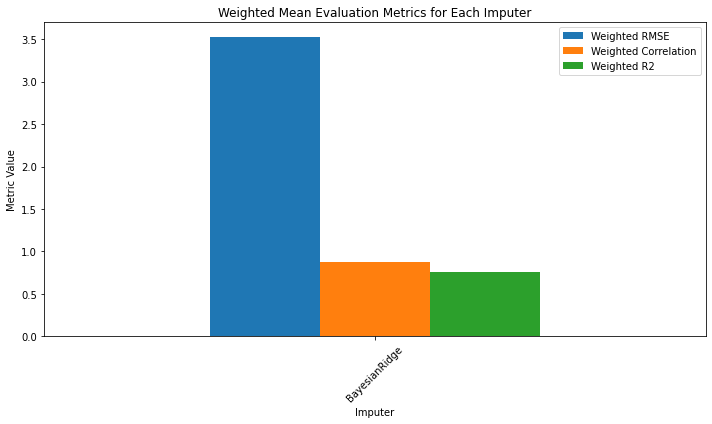

In [ ]:

# Calculate the weighted mean for each metric
# weighted_means = results_df.groupby('Imputer').apply(
#     lambda x: np.average(x[['RMSE', 'Correlation', 'R2']], weights=x['Sample_Size'], axis=0)
# )
# weighted_means.columns = ['Weighted_RMSE', 'Weighted_Correlation', 'Weighted_R2']
weighted_means = results_df.groupby('Imputer').apply(
    lambda x: pd.Series(np.average(x[['RMSE', 'Correlation', 'R2']], weights=x['Sample_Size'], axis=0), 
                        index=['Weighted_RMSE', 'Weighted_Correlation', 'Weighted_R2'])
)
# Display the weighted means
print(weighted_means)

# Visualization
weighted_means.plot(kind='bar', figsize=(10, 6))
plt.title('Weighted Mean Evaluation Metrics for Each Imputer')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(['Weighted RMSE', 'Weighted Correlation', 'Weighted R2'])
plt.tight_layout()
plt.show()


In [ ]:
asd
mice_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)

# Initialize a list to store the comparison results for each fold
comparison_results = []
missingness_fraction = 0.1  # Fraction of values to be made missing in the test set

# Initialize an array to store the MSE for each fold
mse_scores = []
numerical_data = df.select_dtypes(include=[np.number])
numerical_data = numerical_data.astype(np.float64)

numerical_data_cols = numerical_data.columns

fold_by = 'survey'
fold_gen = fold_generator(df, fold_by, n_splits=5)
# Iterate over each fold
for fold, (train_index, test_index) in enumerate(fold_gen):
    X_train, X_test = numerical_data.iloc[train_index], numerical_data.iloc[test_index]

    # Introduce artificial missing values in a copy of X_test
    X_test_with_missing = X_test.copy()
    missing_mask = np.zeros(X_test_with_missing.shape, dtype=bool)  # Initialize the mask
    print(len(X_train), len(X_test), len(missing_mask))
    for col in X_test_with_missing.columns:
        # Identify non-missing values
        non_missing_indices = X_test_with_missing[col].dropna().index
        # Randomly select 10% of the non-missing values to replace with NaN
        random_sample = np.random.choice(non_missing_indices, size=int(np.ceil(0.1 * len(non_missing_indices))), replace=False)
        
        # Get the local indices of the randomly selected samples
        local_indices = X_test_with_missing.index.get_indexer(random_sample)

        # Update the mask
        missing_mask[local_indices, X_test_with_missing.columns.get_loc(col)] = True
        
        X_test_with_missing.loc[random_sample, col] = np.nan

    # Apply imputation on the test set with artificially introduced missing values
    X_test_imputed = mice_imputer.fit(X_train).transform(X_test_with_missing)
    X_test_imputed = pd.DataFrame(X_test_imputed, index=X_test_with_missing.index, 
                                  columns=X_test_with_missing.columns)
    break


NameError: name 'asd' is not defined

In [ ]:
# Compare the imputed values with the actual original values
for col in X_test.columns:
    mask = missing_mask[:, X_test.columns.get_loc(col)]
    original_values = X_test.loc[mask, col]
    imputed_values = X_test_imputed.loc[mask, col]
    # pd.Series(X_test_imputed[X_test_with_missing[col].isnull(), X_test.columns.get_loc(col)], index=original_values.index)
    # Calculate some metric (e.g., MSE) to assess the accuracy of the imputed values
    rmse = np.sqrt(mean_squared_error(original_values, imputed_values))
    r = np.corrcoef(original_values, imputed_values)[0, 1]
    r2 = r2_score(original_values, imputed_values)
    print(col, rmse, r, r2)
    # Append your analysis result to the comparison_results list
    comparison_results.append(rmse)


Meta; year 4.2881252767052525 0.8031209819267271 0.5587415436633855
DHS Num; number of household members: mean 0.629131198485554 0.9252945462696289 0.852210937125914
DHS Num; owns sheep: mean 1.8283812022108072 0.4748433095601726 0.1921027140751621
DHS Num; number of eligible children for height and weight: mean 0.2807945663140002 0.8327120261154907 0.6451068041232825
DHS Num; total adults measured: mean 0.5157848642693318 0.3686947913574529 -0.16850219187571036
DHS Num; number of mosquito bed nets: mean 0.6624566037027173 0.5661693685820657 0.19008082128193826
DHS Num; cluster altitude in meters: mean 614.1568029342473 0.5196967671730296 0.2092016736411484
DHS Num; number of eligible women in household: mean 0.18878616390564948 0.8398201639451254 0.6904328731956553
DHS Num; number of children 5 and under (de jure): mean 0.20923735747531677 0.8600879448780294 0.7300661704807
DHS Num; number of households sharing toilet: mean 0.8250433761584982 0.9756722480927541 0.9505751333244807
DHS 

In [ ]:
asd
# Setting up the MICE imputer using the Bayesian Ridge regressor
mice_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)

# Impute the dataset
# Note: Ensure the dataset (`data`) is ready for imputation (appropriate encoding, scaling if necessary, etc.)
data_imputed = mice_imputer.fit_transform(df.select_dtypes(include=[np.number]))

# Converting the imputed data back to a DataFrame
data_imputed_df = pd.DataFrame(data_imputed, columns=df.select_dtypes(include=[np.number]).columns)

# Displaying the imputed dataset
data_imputed_df.head()


NameError: name 'asd' is not defined

In [ ]:
# Adjusting the number of features and the complexity of the Random Forest regressor for quicker execution
feature_columns = data.select_dtypes(include=[np.number]).columns[:5]  # Reduce number of features for simplicity

# Update the imputer to use a simpler model for speed
def impute_mice_rf_simplified(data, max_iter=10, n_estimators=5, max_depth=3):
    imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=n_estimators, 
                                                               max_depth=max_depth, 
                                                               random_state=0),
                               max_iter=max_iter, random_state=0)
    return pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

imputers['mice_rf'] = impute_mice_rf_simplified

# Re-run the k-fold cross-validation with the updated settings
X = data[feature_columns].copy()
mse_results = {'knn': [], 'mice_bayesian': [], 'mice_rf': []}

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for method_name, imputer_func in imputers.items():
        # Impute missing values in training and testing sets
        X_train_imputed = imputer_func(X_train)
        X_test_imputed = imputer_func(X_test)
        
        # Train a linear regression model
        model = LinearRegression()
        model.fit(X_train_imputed, y_train)
        
        # Predict and evaluate the model
        y_pred = model.predict(X_test_imputed)
        mse = mean_squared_error(y_test, y_pred)
        mse_results[method_name].append(mse)

# Visualize the results
fig, ax = plt.subplots()
for method_name, mses in mse_results.items():
    ax.plot(mses, label=method_name)
ax.set_xlabel('Fold')
ax.set_ylabel('Mean Squared Error')
ax.set_title('MSE across folds for different imputation methods')
ax.legend()
plt.show()


In [ ]:
# KNN Imputer function
def impute_knn(data, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    return pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# MICE Imputer function with Bayesian Ridge Regression
def impute_mice_bayesian(data, max_iter=10):
    imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=max_iter, random_state=0)
    return pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# MICE Imputer function with Random Forest
def impute_mice_rf(data, max_iter=10, n_estimators=10):
    imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=n_estimators, random_state=0),
                               max_iter=max_iter, random_state=0)
    return pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Create a dictionary of imputers for easy access
imputers = {
    'knn': impute_knn,
    'mice_bayesian': impute_mice_bayesian,
    'mice_rf': impute_mice_rf
}

# Now the functions are ready to be used for imputation. You can call these functions and pass your dataset to them.
